<a href="https://colab.research.google.com/github/datasciencecompleteguide/Hard/blob/master/task4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **IMAGE** **CLASSIFICATION**

Importing useful libraries

In [ ]:
# LIBRARIES
import glob
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import Image,ImageOps
from sklearn.decomposition import PCA
from keras.optimizers import Adam,RMSprop
import matplotlib.pyplot as plt
from skimage import restoration 

Setting local variables and data path

In [ ]:
batch_size = 16#int(input("Enter batch size: "))
n_epochs = 5#int(input("Enter number of epochs: "))
t_size = 150 #int(input("Enter target size: "))

train_path = '/content/drive/MyDrive/task4/bees/train'
test_path = '/content/drive/MyDrive/task4/bees/test'
val_path = '/content/drive/MyDrive/task4/bees/validate'
val_datagen = ImageDataGenerator(rescale=1./255)
val_data = val_datagen.flow_from_directory(train_path, target_size=(t_size,t_size), batch_size=batch_size,
                                              class_mode='categorical',color_mode = 'rgb')

Found 4143 images belonging to 4 classes.


Showing up one of the images from val_data

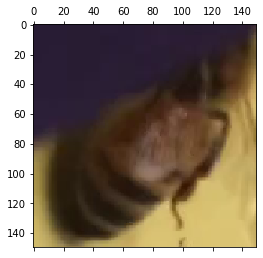

In [ ]:
plt.matshow(val_data[0][0][1])
plt.show()

Dealing with input shape format either (height, width, channel) or (channel,height, width)

In [ ]:
from keras import backend as k
if k.image_data_format() == 'channel_first':
    input_shape = (3,t_size,t_size)
else:
    input_shape = (t_size,t_size,3)

In [ ]:
input_shape

(150, 150, 3)

Extracting image data with its corresponding class label

In [ ]:
def extractimages(path,t):
  classes = glob.glob(path+"/*")
  y = []
  all_images = []
  arrayformatimages = []

  for class_ in classes:
    image_names = glob.glob(class_+"/*")
    all_images.append(image_names) 

  counter = 0 
  for class_ in all_images:
    for image in class_:
      
      img = Image.open(image).resize(((t,t)))
      img = (np.asarray(img))
      if img.shape == (t,t,3):
        img = img.reshape(-1,3)
        arrayformatimages.append(img)
        y.append(counter)
    counter = counter + 1
  return arrayformatimages,y


arrayformatimages,y = extractimages(train_path,t_size)

Generating training Image data and validation Image data

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)
val_data = datagen.flow_from_directory(test_path,target_size=(150,150), 
                                                batch_size=64, 
                                                class_mode='categorical')
train_data = datagen.flow_from_directory(train_path,target_size=(150,150), 
                                                batch_size=64, 
                                                class_mode='categorical',shuffle = True)

Found 500 images belonging to 4 classes.
Found 4143 images belonging to 4 classes.


Performing Image preprocessing technique
### PCA

In [ ]:
total_samples = len(arrayformatimages)
x = np.array(arrayformatimages,dtype=object)
y = np.array(y)

In [ ]:
def pca_image(arr):
  pca = PCA(2)
  l = []
  for i in arr:
    fitted = pca.fit_transform(i)
    restoring = pca.inverse_transform(fitted)
    final = np.reshape(restoring,(-1,150,3))
    ffinal = np.uint8(final)
    l.append(ffinal)
  return l
x = pca_image(x)

Converting lable into categorical form

In [ ]:
x = np.array(x)
arr = x.reshape(total_samples,t_size,t_size,3)

from keras.utils import to_categorical
#one-hot encode target column
y = to_categorical(y)

**Preparing Convolutional Neural Network**

In [ ]:
model = tf.keras.models.Sequential([
        # Note the input shape is the desired size of the image 200x 200 with 3 bytes color
        # The first convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150,150,3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        # The fourth convolution
        tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
        # The fifth convolution
        tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(128,(2,2), activation='relu', kernel_regularizer =tf.keras.regularizers.l1( l=0.01)),
        tf.keras.layers.MaxPooling2D(2,2),
        # 128 neuron in the fully-connected layer
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4, activation='softmax')
    ])

#setting up optimizer
opt = RMSprop(0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['acc'])

history = model.fit(arr,y, validation_data = val_data, epochs=5, verbose=1)

Epoch 1/5
129/129 [==============================] - 7s 44ms/step - loss: 31.3202 - acc: 0.5717 - val_loss: 6.0988 - val_acc: 0.2100
Epoch 2/5
129/129 [==============================] - 5s 40ms/step - loss: 2.8417 - acc: 0.6974 - val_loss: 3.5180 - val_acc: 0.2100
Epoch 3/5
 99/129 [======================>.......] - ETA: 0s - loss: 1.1705 - acc: 0.7661

KeyboardInterrupt: ignored

### Model report; Accuracy and Loss



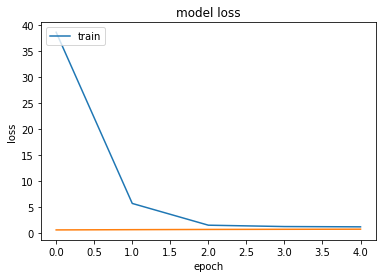

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

**Preparing another model without Image preprocessing**

In [ ]:
model2 = tf.keras.models.Sequential([
        # Note the input shape is the desired size of the image 200x 200 with 3 bytes color
        # The first convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150,150,3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        # The fourth convolution
        tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
        # The fifth convolution
        tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(128,(2,2), activation='relu', kernel_regularizer =tf.keras.regularizers.l1( l=0.01)),
        tf.keras.layers.MaxPooling2D(2,2),
        # 128 neuron in the fully-connected layer
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4, activation='softmax')
    ])

#Setting up optimizer
opt2 = RMSprop(0.001)
model2.compile(loss='categorical_crossentropy',
              optimizer=opt2,
              metrics=['acc'])

history2 = model2.fit(train_data, validation_data = val_data, epochs=5, verbose=1)

Epoch 1/5
65/65 [==============================] - 11s 152ms/step - loss: 15.3004 - acc: 0.6288 - val_loss: 1.3924 - val_acc: 0.7260
Epoch 2/5
65/65 [==============================] - 9s 133ms/step - loss: 1.1986 - acc: 0.7361 - val_loss: 0.9989 - val_acc: 0.7620
Epoch 3/5
65/65 [==============================] - 9s 132ms/step - loss: 0.9229 - acc: 0.7979 - val_loss: 0.7951 - val_acc: 0.8660
Epoch 4/5
65/65 [==============================] - 9s 134ms/step - loss: 0.7944 - acc: 0.8488 - val_loss: 0.7622 - val_acc: 0.8760
Epoch 5/5
65/65 [==============================] - 9s 133ms/step - loss: 0.7576 - acc: 0.8516 - val_loss: 0.7122 - val_acc: 0.8800


### Model2 report; Accuracy and Loss

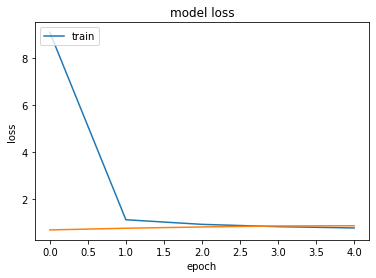

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()